In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import SubsetRandomSampler, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters and constants
BATCH_SIZE = 64
NUM_TRAIN = 49000
EPOCHS = 10

PRINT_EVERY = 100

SAVE_MODEL = False

R_MEAN = 0.4914
G_MEAN = 0.4822
B_MEAN = 0.4465
R_STD = 0.2023
G_STD = 0.1994
B_STD = 0.2010

# Use GPU if available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [3]:
# Set random seed for replicating testing results
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [4]:
# Normalise the dataset
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
            ])
# Augement and normalise the dataset
transform_aug = T.Compose([
                  T.RandomCrop(32, padding=4),
                  T.RandomHorizontalFlip(p=0.5),
                  T.ToTensor(),
                  T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
                ])

In [5]:
# Load CIFAR10
training_dataset   = torchvision.datasets.CIFAR10('data/', train=True,  transform=transform_aug, download=True)
validation_dataset = torchvision.datasets.CIFAR10('data/', train=True,  transform=transform, download=True)
testing_dataset    = torchvision.datasets.CIFAR10('data/', train=False, transform=transform, download=True)


# Create dataloaders
training_data   = DataLoader(training_dataset,   batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(range(NUM_TRAIN)))
validation_data = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(range(NUM_TRAIN,50000)))
testing_data    = DataLoader(testing_dataset,    batch_size=BATCH_SIZE, shuffle=False)

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Files already downloaded and verified


In [6]:
class MyModel(nn.Module):
    def __init__(self, no_classes=10):
        super(MyModel, self).__init__()
        
        self.network = nn.Sequential(
                        nn.Conv2d(3,    32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(32,   32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(32,  64, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
            
                        nn.AvgPool2d(kernel_size=4),
            
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features=no_classes, bias=True)
                       )
        
    def forward(self, x):
        return self.network(x)

In [14]:
class MyModel2(nn.Module):
    def __init__(self, no_classes=10):
        super(MyModel2, self).__init__()
        
        self.network = nn.Sequential(
                        nn.Conv2d(3,    32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.2),
            
                        nn.Conv2d(32,   32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.2),
            
                        nn.Conv2d(32,  64, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.2),
            
                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.2),
            
                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.2),
            
                        nn.AvgPool2d(kernel_size=4),
            
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features=no_classes, bias=True)
                       )
        
    def forward(self, x):
        return self.network(x)

In [15]:
def loss_function(preds, y):
    return F.cross_entropy(preds,y)

In [16]:
def evaluate(model):
    model.eval()
    with torch.no_grad():
      correct_preds = 0
      total_preds = 0

      for x_test,y_test in testing_data:
        x_test = x_test.to(device=device, dtype=torch.float32)
        y_test = y_test.to(device=device, dtype=torch.long)

        results = model(x_test)
        _,preds = results.max(1)

        correct_preds += (preds == y_test).sum()
        total_preds += preds.size(0)

      acc = 100.0 * correct_preds / total_preds

      print('Correctly predicted: {}/{}, with accuracy={:.2f}%'.format(correct_preds,total_preds,acc))

In [17]:
# Keep track training losses
valid_losses = [[],[]]

def validate(model, idx):
  model.eval()

  loss = []
  with torch.no_grad():
    for x_validate,y_validate in validation_data:
      x_validate = x_validate.to(device=device, dtype=torch.float32)
      y_validate = y_validate.to(device=device, dtype=torch.long)

      preds = model(x_validate)

      loss.append(loss_function(preds, y_validate).item())

    valid_losses[idx].append(np.mean(loss))

In [18]:
# Keep track training losses
train_losses = [[],[]]

def training(model, model2, optimiser, optimiser2):
    for epoch in range(EPOCHS):
        for idx,(x_train,y_train) in enumerate(training_data):
            model.train()
            model2.train()

            x_train = x_train.to(device=device, dtype=torch.float32)
            y_train = y_train.to(device=device, dtype=torch.long)

            preds  = model(x_train)
            preds2 = model2(x_train)

            loss  = loss_function(preds, y_train)
            loss2 = loss_function(preds2, y_train)

            optimiser.zero_grad()
            optimiser2.zero_grad()

            loss.backward()
            loss2.backward()

            optimiser.step()
            optimiser2.step()

            if idx % PRINT_EVERY == 0:
                print('Epoch: %d, iteration %d, loss=%.3f, loss2=%.3f' % (epoch, idx, loss.item(), loss2.item()))
                train_losses[0].append(loss.item())
                train_losses[1].append(loss2.item())

                validate(model,  0)
                validate(model2, 1)

In [19]:
model = MyModel()
model.to(device=device)
model2 = MyModel2()
model2.to(device=device)

optimiser = optim.Adam(model.parameters())
optimiser2 = optim.Adam(model2.parameters())

In [20]:
training(model, model2, optimiser, optimiser2)

# save the model
if SAVE_MODEL:
    torch.save(model.state_dict(), 'model.pt')
    torch.save(model2.state_dict(), 'model2.pt')

Epoch: 0, iteration 0, loss=2.277, loss2=2.329
Epoch: 0, iteration 100, loss=1.619, loss2=1.677
Epoch: 0, iteration 200, loss=1.508, loss2=1.481
Epoch: 0, iteration 300, loss=1.533, loss2=1.610
Epoch: 0, iteration 400, loss=1.320, loss2=1.401
Epoch: 0, iteration 500, loss=1.250, loss2=1.338
Epoch: 0, iteration 600, loss=1.333, loss2=1.524
Epoch: 0, iteration 700, loss=1.207, loss2=1.296
Epoch: 1, iteration 0, loss=0.998, loss2=1.064
Epoch: 1, iteration 100, loss=1.356, loss2=1.398
Epoch: 1, iteration 200, loss=0.979, loss2=1.166
Epoch: 1, iteration 300, loss=0.973, loss2=1.093
Epoch: 1, iteration 400, loss=0.985, loss2=1.127
Epoch: 1, iteration 500, loss=0.932, loss2=1.139
Epoch: 1, iteration 600, loss=1.179, loss2=1.337
Epoch: 1, iteration 700, loss=0.842, loss2=1.029
Epoch: 2, iteration 0, loss=0.849, loss2=1.015
Epoch: 2, iteration 100, loss=1.024, loss2=1.119
Epoch: 2, iteration 200, loss=0.930, loss2=1.104
Epoch: 2, iteration 300, loss=0.971, loss2=1.138
Epoch: 2, iteration 400, l

Correctly predicted: 7528/10000, with accuracy=75.28%
Correctly predicted: 7239/10000, with accuracy=72.39%


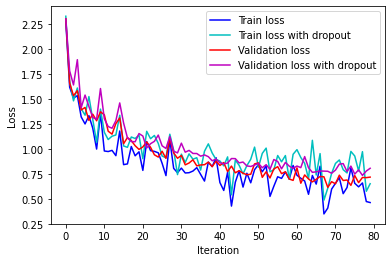

In [21]:
evaluate(model)
evaluate(model2)

plt.plot(train_losses[0], 'b')
plt.plot(train_losses[1], 'c')
plt.plot(valid_losses[0], 'r')
plt.plot(valid_losses[1], 'm')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['Train loss','Train loss with dropout','Validation loss','Validation loss with dropout'])
plt.show()